In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [3]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Note**: Every invoice should have a CustomerID. Without CustomerID, we cannot perform RFM analysis, so we are dropping those entries where CustomerID is missing

In [13]:
df = df.dropna(subset=['CustomerID'])

In [14]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

It seems all the entries with misssing Description also had missing CustomerID, so they also got dropped during the cleaning process.

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
reference_date = df['InvoiceDate'].max()
reference_date

Timestamp('2011-12-09 12:50:00')

In [17]:
reference_date

Timestamp('2011-12-09 12:50:00')

In [18]:
# Step 1: Calculate Recency
# Recency is the number of days since the customer's last purchase
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (reference_date - recency['InvoiceDate']).dt.days
recency = recency[['CustomerID', 'Recency']]  # Keep only CustomerID and Recency

In [19]:
recency

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4367,18280.0,277
4368,18281.0,180
4369,18282.0,7
4370,18283.0,3


In [20]:
# Step 2: Calculate Frequency
# Frequency is the number of unique invoices per customer
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency = frequency.rename(columns={'InvoiceNo': 'Frequency'})
frequency

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4367,18280.0,1
4368,18281.0,1
4369,18282.0,3
4370,18283.0,16


In [21]:
# Step 3: Calculate Monetary
# Monetary is the total revenue generated by each customer
monetary = df.groupby('CustomerID').apply(
    lambda x: (x['UnitPrice'] * x['Quantity']).sum()
).reset_index()
monetary = monetary.rename(columns={0: 'Monetary'})
monetary

/var/folders/5m/j6vy15712wdbb9xdp1dmy0jw0000gn/T/ipykernel_56083/3031641007.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monetary = df.groupby('CustomerID').apply(


,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [22]:
# Step 4: Combine Recency, Frequency, and Monetary into a single DataFrame
rfm_data = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm_data

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4367,18280.0,277,1,180.60
4368,18281.0,180,1,80.82
4369,18282.0,7,3,176.60
4370,18283.0,3,16,2094.88


We are using pd.qcut() to divide the column into 4 quartiles and assign labels.
- Q1 (First Quartile): 0% to 25% of the data.
- Q2 (Second Quartile/Median): 25% to 50% of the data.
- Q3 (Third Quartile): 50% to 75% of the data.
- Q4 (Fourth Quartile): 75% to 100% of the data.

In [24]:
def assign_rfm_score(column, ascending=True):
    """
    Assigns a score from 1 to 4 based on quartiles.
    - If ascending is True: Lower values get higher scores (e.g., Recency)
    - If ascending is False: Higher values get higher scores (e.g., Frequency, Monetary)
    """
    
    num_bins = len(pd.qcut(column, 5, duplicates='drop').unique())
    
    
    if ascending:
        labels = list(range(num_bins, 0, -1))  # e.g., [4, 3, 2, 1] if 4 bins, [3, 2, 1] if 3 bins
    else:
        labels = list(range(1, num_bins + 1))  # e.g., [1, 2, 3, 4] if 4 bins, [1, 2, 3] if 3 bins
    
    return pd.qcut(column, q=num_bins, labels=labels, duplicates='drop')

In [25]:
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_data['M_Score'] = assign_rfm_score(rfm_data['Monetary'], ascending=False)


rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)


rfm_data.dtypes

CustomerID     float64
Recency          int64
Frequency        int64
Monetary       float64
R_Score       category
F_Score       category
M_Score       category
RFM_Score       object
dtype: object

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Convert R, F, M scores to integers
rfm_data['R_Score'] = rfm_data['R_Score'].astype(int)
rfm_data['F_Score'] = rfm_data['F_Score'].astype(int)
rfm_data['M_Score'] = rfm_data['M_Score'].astype(int)

# Prepare the data for clustering
rfm_features = rfm_data[['R_Score', 'F_Score', 'M_Score']]

In [27]:
rfm_features

,R_Score,F_Score,M_Score
0,1,2,1
1,5,4,5
2,2,3,4
3,4,1,4
4,1,1,2
...,...,...,...
4367,1,2,1
4368,1,2,1
4369,5,3,1
4370,5,5,5


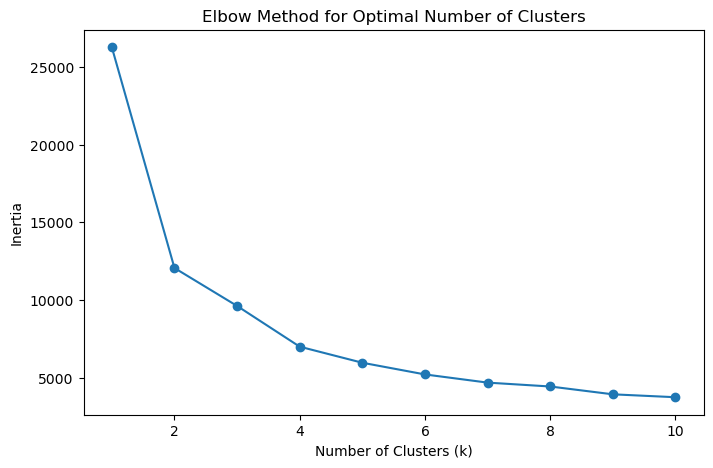

In [28]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
cluster_range = range(1, 11)  # Testing from 1 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [29]:
# Apply K-Means with the chosen number of clusters (e.g., k = 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_features)

# Display the first few rows with the cluster assignments
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Cluster
0,12346.0,325,2,0.00,1,2,1,121,3
1,12347.0,1,7,4310.00,5,4,5,545,2
2,12348.0,74,4,1797.24,2,3,4,234,1
3,12349.0,18,1,1757.55,4,1,4,414,0
4,12350.0,309,1,334.40,1,1,2,112,3


In [30]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   float64
 1   Recency     4372 non-null   int64  
 2   Frequency   4372 non-null   int64  
 3   Monetary    4372 non-null   float64
 4   R_Score     4372 non-null   int64  
 5   F_Score     4372 non-null   int64  
 6   M_Score     4372 non-null   int64  
 7   RFM_Score   4372 non-null   object 
 8   Cluster     4372 non-null   int32  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 290.5+ KB


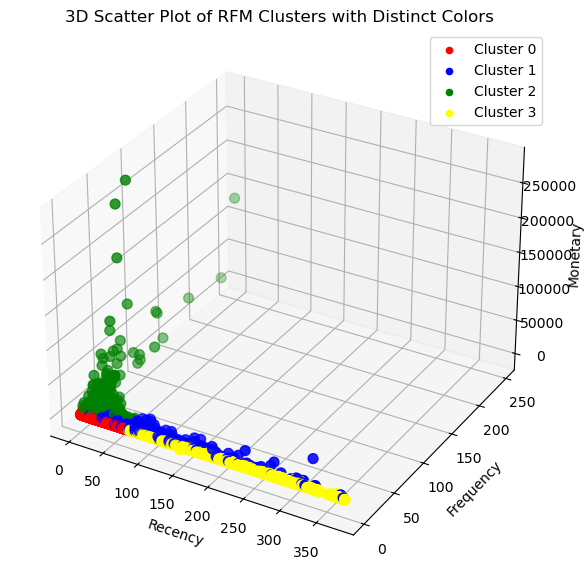

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a list of distinct colors
colors = ['red', 'blue', 'green', 'yellow']

# Map each cluster to a distinct color
rfm_data['Color'] = rfm_data['Cluster'].apply(lambda x: colors[x])

# Create a 3D scatter plot with distinct colors for each cluster
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm_data['Recency'], 
    rfm_data['Frequency'], 
    rfm_data['Monetary'], 
    color=rfm_data['Color'],  # Use distinct colors
    s=50
)
ax.set_title('3D Scatter Plot of RFM Clusters with Distinct Colors')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Add a legend for clusters
for i in range(len(colors)):
    if i in rfm_data['Cluster'].unique():
        ax.scatter([], [], [], color=colors[i], label=f'Cluster {i}')

plt.legend()
plt.show()

In [32]:
cluster_summary = rfm_data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score']].mean()
cluster_summary[['R_Score','F_Score','M_Score']]
cluster_summary['Avg Score'] = (cluster_summary['R_Score'] + cluster_summary['F_Score'] +cluster_summary['M_Score'])/3
cluster_summary
# cluster_summary.reset_index()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Avg Score
Cluster,,,,,,,
0,30.313327,1.738555,385.673499,3.794507,2.043744,1.990844,2.609698
1,85.044239,4.413580,1417.960507,2.541152,3.649177,3.733539,3.307956
2,12.882201,12.361135,5289.332442,4.511608,4.606191,4.553740,4.557180
3,215.801435,1.447368,311.959746,1.367624,1.756778,1.781499,1.635300


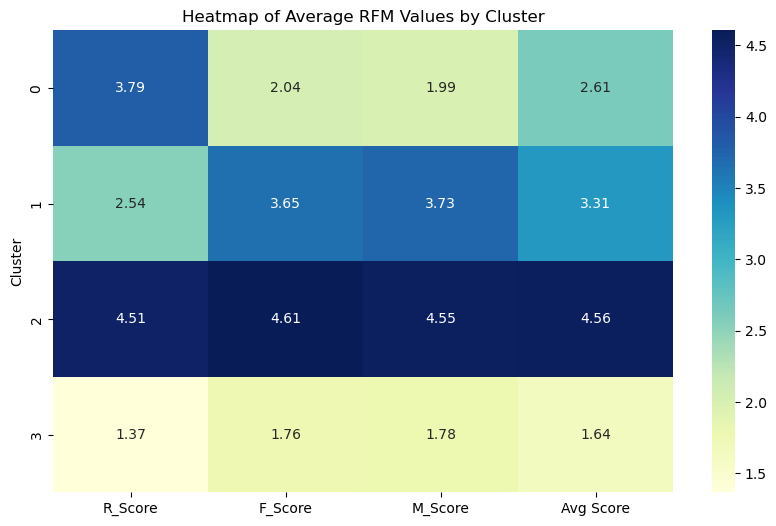

In [33]:
# Create a heatmap to visualize the average R, F, M scores for each cluster
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary[['R_Score','F_Score','M_Score', 'Avg Score']], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Average RFM Values by Cluster')
plt.show()

## Segment Profiling and Analysis based on Clustering:
Let's analyze and profile each customer segment based on their RFM metrics and average scores to understand their characteristics.

#### **Cluster 0**
- **Recency**: 21.53 days (on average)
- **Frequency**: 1.91 purchases
- **Monetary**: $359.77
- **RFM Scores**:
  - **R_Score**: 3.40 (high score; recent buyers)
  - **F_Score**: 1.23 (low score; infrequent purchases)
  - **M_Score**: 1.63 (low score; low spending)
- **Avg Score**: 2.09

**Profile**: 
- **Customer Type**: New or Recently Engaged Buyers
- **Characteristics**: 
  - These customers have purchased recently but do not buy frequently and spend relatively little. 
  - They may be new to the brand or only make occasional purchases. 

#### **Cluster 1**
- **Recency**: 13.99 days
- **Frequency**: 11.71 purchases
- **Monetary**: $4929.52
- **RFM Scores**:
  - **R_Score**: 3.66 (very high score; very recent buyers)
  - **F_Score**: 2.85 (moderate score; frequent buyers)
  - **M_Score**: 3.64 (high score; high spending)
- **Avg Score**: 3.39

**Profile**: 
- **Customer Type**: High-Value Loyal Customers
- **Characteristics**: These customers buy very frequently, spend significantly, and have made recent purchases. 
- They are likely the most valuable segment. 


#### **Cluster 2**
- **Recency**: 98.27 days
- **Frequency**: 3.93 purchases
- **Monetary**: $1414.92
- **RFM Scores**:
  - **R_Score**: 2.01 (moderate score; less recent buyers)
  - **F_Score**: 1.97 (low to moderate frequency)
  - **M_Score**: 3.15 (high score; relatively high spending)
- **Avg Score**: 2.38

**Profile**: 
- **Customer Type**: Moderate Spenders
- **Characteristics**: 
  - These customers do not purchase as frequently and have not purchased recently
  - They do spend a fair amount when they do buy. 

#### **Cluster 3**
- **Recency**: 193.79 days
- **Frequency**: 1.46 purchases
- **Monetary**: $264.42
- **RFM Scores**:
  - **R_Score**: 1.35 (low score; last purchase was a long time ago)
  - **F_Score**: 1.09 (very low frequency)
  - **M_Score**: 1.43 (low score; low spending)
- **Avg Score**: 1.29

**Profile**: 
- **Customer Type**: Inactive or At-Risk Customers
- **Characteristics**: 
  - These customers have not made a purchase in a long time.
  - They rarely buy products
  - They spend very little

## Marketing Recommendations:

### **Cluster 0: New or Recently Engaged Buyers**
These customers have recently made a purchase but aren’t frequent shoppers, and they don’t spend much. The goal here is to keep them engaged and encourage repeat purchases.
- Welcome Campaign**: We can kick things off with a personalized welcome email series. Highlight popular products, new arrivals, and give them a special discount for their next purchase. It’s all about making them feel valued right from the start.
- Encourage Repeat Purchases**: Offering a time-sensitive deal, like a discount that expires soon, or setting up a reward system for multiple purchases can motivate them to buy again.
- Engaging Content**: Keep them interested by sharing product tips, how-to videos, or educational content related to their interests. It’s a great way to keep our brand top-of-mind.
- Seek Feedback**: A simple “How was your experience?” can go a long way. We can use their input to make improvements and show that we care about their opinion.


### **Cluster 1: High-Value Loyal Customers**
These are our superstar customers! They buy often, spend a lot, and have shopped with us recently. Our main job is to keep them happy and feeling appreciated.
- Loyalty Program**: Let’s roll out a VIP program. Think early access to new collections, birthday rewards, and exclusive discounts. They’ll love the special treatment.
- Personalized Offers**: Using their shopping history, we can offer tailored product recommendations and unique deals just for them. Making it personal shows we value their loyalty.
- Show Appreciation**: A heartfelt thank-you note or a surprise gift can make a big impact. These little gestures can strengthen their emotional connection to our brand.
- Referral Program**: We can reward them for referring friends and family, giving them even more reason to share their love for our brand while expanding our customer base.


### **Cluster 2: Moderate Spenders**
This group spends a decent amount but isn’t very frequent in their shopping, and it’s been a while since their last visit. We need to re-engage them and encourage more frequent purchases.
- Win-Back Campaigns**: Let’s reach out with a personalized email that reminds them of their favorite products, offers a special discount, or creates urgency with a limited-time promotion.
- Seasonal Promotions**: Leveraging holidays or seasonal sales could grab their attention and give them a reason to shop with us.
- Bundle Deals**: We can entice them with bundled offers or discounts on larger purchases. It makes buying feel like a smarter deal.
- Exclusive Previews**: Giving them early access to upcoming collections or limited-edition items can make them feel special and keep them engaged.


### **Cluster 3: Inactive or At-Risk Customers**
These customers haven’t shopped with us in a long time, and when they do, they don’t spend much. Re-engaging them is a challenge, but it’s worth a shot.
- Win-Back Email Series**: A heartfelt “We miss you!” email with a special offer or free shipping might be the nudge they need. Creating urgency with limited-time deals can help.
- Surprise Offers**: A little surprise gift or a spontaneous discount can make them feel valued and tempted to shop again.
- Reactivation Incentives**: Sweeten the deal with offers like loyalty point boosts or a significant discount if they make a purchase within a specific time frame.
- Know When to Let Go**: If we can’t win them back, it might be wise to move them off our active marketing list. Instead, we can send them occasional updates, just in case they decide to come back one day.


### **Overall Strategy**
We can use data-driven personalization to tailor these strategies for each group and make our marketing more impactful. Automation tools will help us deliver the right messages at the right time, and we’ll keep an eye on performance metrics to fine-tune our approach.

By focusing on these personalized strategies, we can boost customer loyalty, increase engagement, and maximize our revenue potential. Let’s get started!

# Segment Profiling and Analysis based on RFM Grid:

![title](rfm_grid.jpeg)

In [35]:
rfm_data['segment'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Cluster,Color,segment
0,12346.0,325,2,0.00,1,2,1,121,3,yellow,12
1,12347.0,1,7,4310.00,5,4,5,545,2,green,54
2,12348.0,74,4,1797.24,2,3,4,234,1,blue,23
3,12349.0,18,1,1757.55,4,1,4,414,0,red,41
4,12350.0,309,1,334.40,1,1,2,112,3,yellow,11


In [ ]:
seg_map = {
r'[1-2][1-2]': 'hibernating',
r'[1-2][3-4]': 'at_risk',
r'[1-2]5': 'cant_loose',
r'3[1-2]': 'about_to_sleep',
r'33': 'need_attention',
r'[3-4][4-5]': 'loyal_customers',
r'41': 'promising',
r'51': 'new_customers',
r'[4-5][2-3]': 'potential_loyalists',
r'5[4-5]': 'champions'
}

# Map RFM segments to corresponding customer segments using predefined seg_map
rfm_data['segment'] = rfm_data['segment'].replace(seg_map, regex=True)

# Keep only relevant columns and return the resulting dataframe
df_rfm = rfm_data[["Recency", "Frequency", "Monetary", "segment"]]

df_rfm.index = df_rfm.index.astype(int)  # Convert index to integer
df_rfm.head()

,Recency,Frequency,Monetary,segment
0,325,2,0.00,hibernating
1,1,7,4310.00,champions
2,74,4,1797.24,at_risk
3,18,1,1757.55,promising
4,309,1,334.40,hibernating


### Detailed RFM Segment Analysis:

### Who are our most profitable customers?

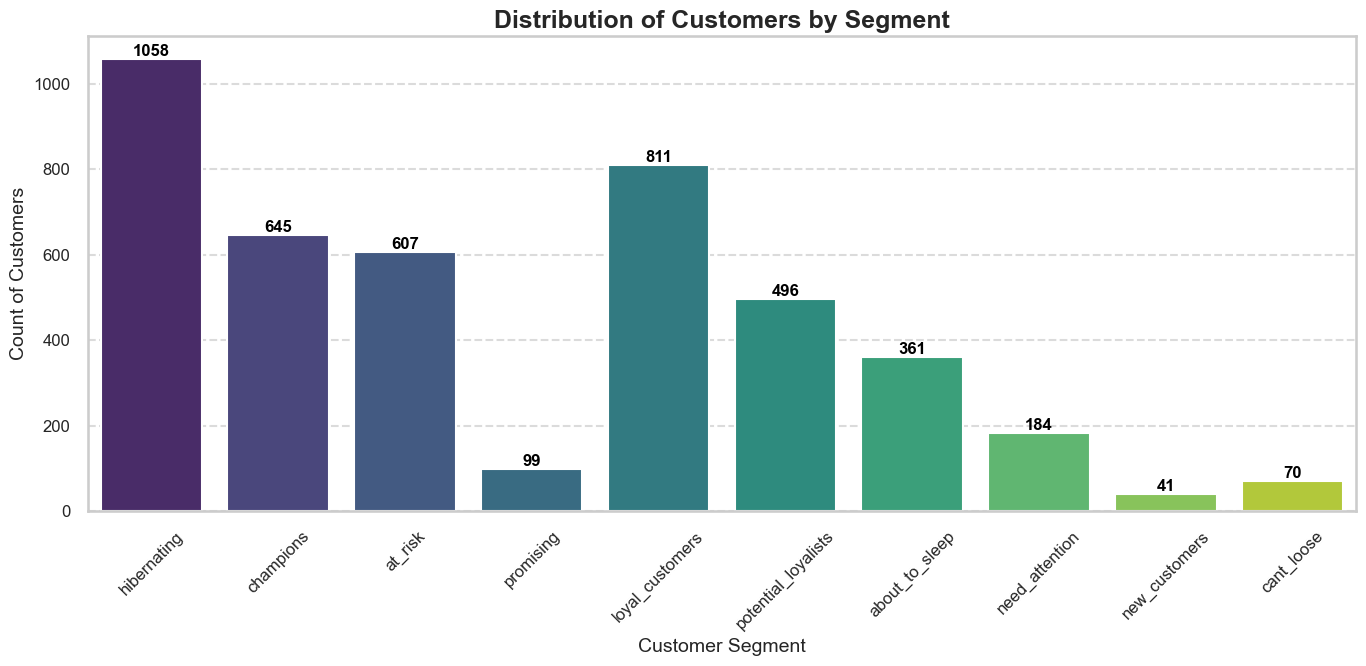

In [46]:
sns.set_style("whitegrid")
sns.set_context("talk")  

plt.figure(figsize=(14, 7))  

sns.countplot(data=df_rfm, x="segment", palette="viridis", hue="segment")


for bar in plt.gca().patches:
    count = int(bar.get_height())  
    plt.annotate(
        text=f"{count}",  
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  
        ha='center',  
        va='bottom',  
        fontsize=12,  
        color='black',  
        fontweight='bold' 
    )

plt.title("Distribution of Customers by Segment", fontsize=18, fontweight="bold")
plt.xlabel("Customer Segment", fontsize=14)
plt.ylabel("Count of Customers", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

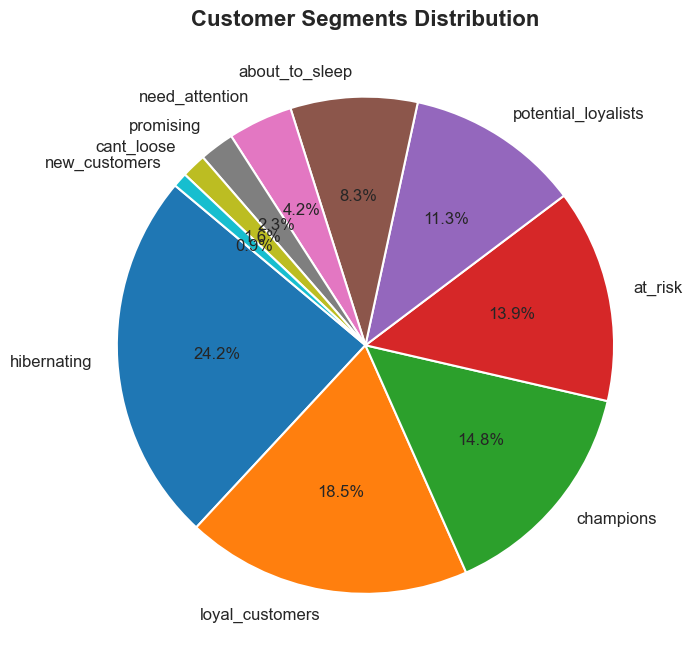

In [49]:
import matplotlib.pyplot as plt

segment_counts = rfm_data['segment'].value_counts()
labels = segment_counts.index 
sizes = segment_counts.values  

plt.figure(figsize=(10, 7))  

plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=140,  
    textprops={'fontsize': 12},
)

plt.title("Customer Segments Distribution", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

### Customer Behavior:

### How long, on average, do customers remain active (between their first and last purchase)

In [50]:
import pandas as pd


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

customer_active_period = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

customer_active_period['active_days'] = (customer_active_period['max'] - customer_active_period['min']).dt.days

average_active_period = customer_active_period['active_days'].mean()

print(f"On average, customers remain active for {average_active_period:.2f} days.")

On average, customers remain active for 133.39 days.


In [51]:
df['TotalProfit'] = df['Quantity'] * df['UnitPrice']
total_profit = df['TotalProfit'].sum()
print(f"Total Profit: {total_profit}")

Total Profit: 8300065.814000001


/var/folders/5m/j6vy15712wdbb9xdp1dmy0jw0000gn/T/ipykernel_56083/3359857241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_profit_df, x='TotalProfit', y='Description', palette='viridis')


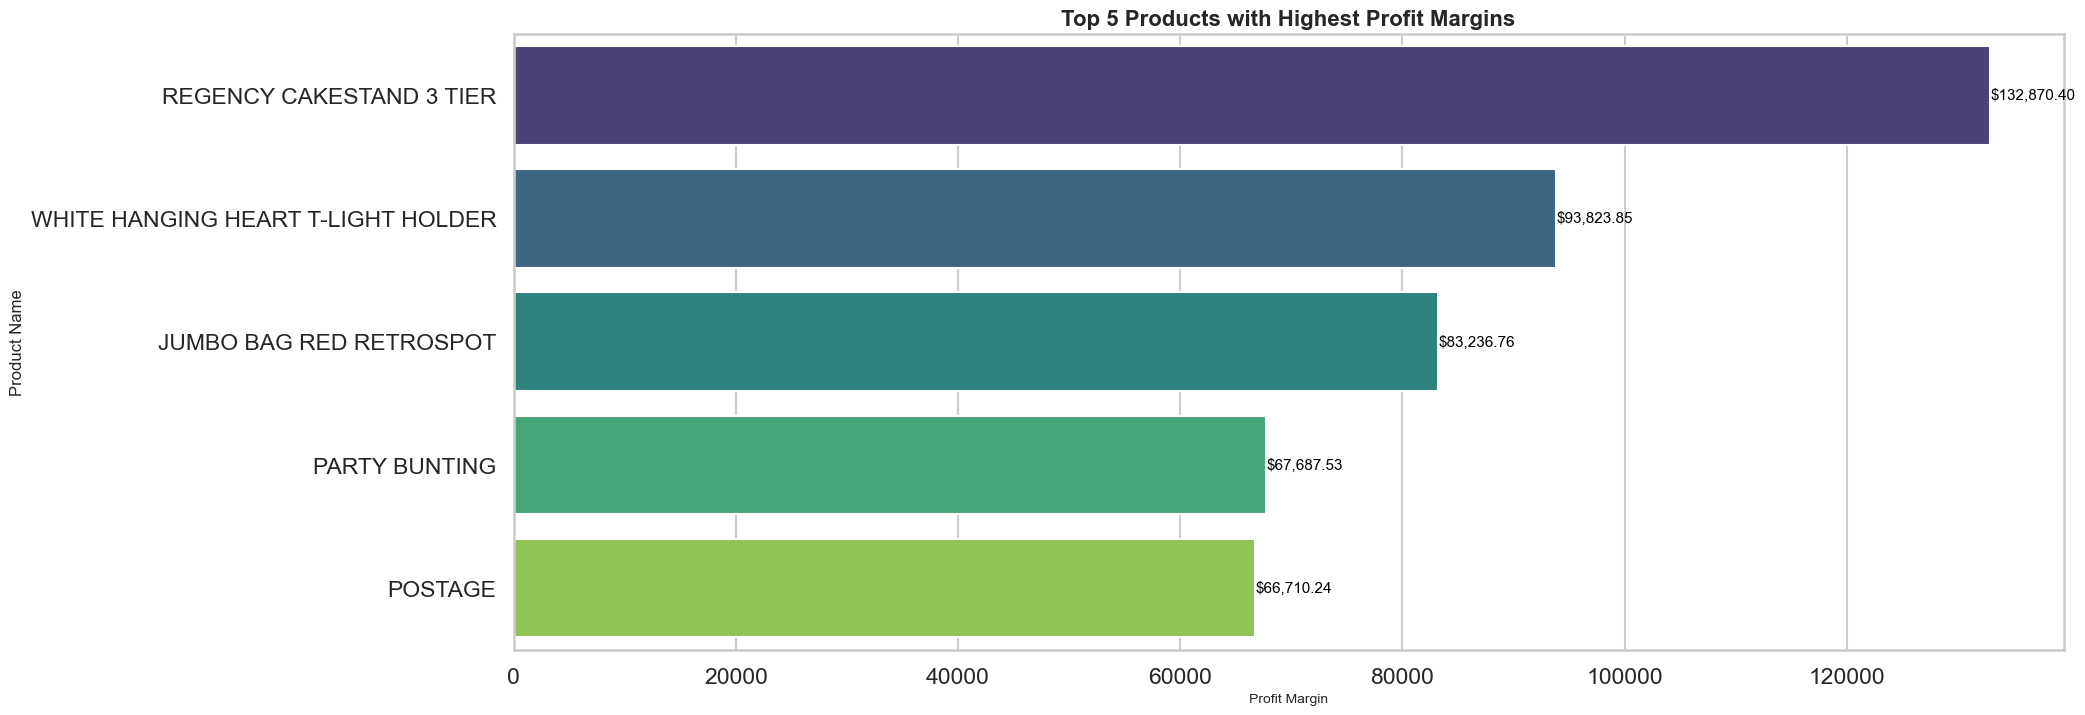

In [60]:
product_profit = df.groupby('Description')['TotalProfit'].sum().sort_values(ascending=False).head(5)

# Convert to DataFrame for plotting
product_profit_df = product_profit.reset_index()

# Plot the bar chart
plt.figure(figsize=(20, 8))
sns.barplot(data=product_profit_df, x='TotalProfit', y='Description', palette='viridis')

# Add annotations for profit margins
for i, (profit, description) in enumerate(zip(product_profit_df['TotalProfit'], product_profit_df['Description'])):
    plt.text(profit + 50, i, f"${profit:,.2f}", va='center', fontsize=11, color='black')

plt.title("Top 5 Products with Highest Profit Margins", fontsize=16, fontweight='bold')
plt.xlabel("Profit Margin", fontsize=10)
plt.ylabel("Product Name", fontsize=12)

plt.show()